In [37]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.remote import Remote

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling,IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv('cryptos_prices.csv', parse_dates=True, index_col='date')
df

,BTC-USD,ETH-USD,XRP-USD,LTC-USD,BCH-USD,ADA-USD,DOT-USD,LINK-USD,DOGE-USD,SOL-USD,TRX-USD,XLM-USD,AVAX-USD,FIL-USD,XTZ-USD,EOS-USD
date,,,,,,,,,,,,,,,,
2014-09-17,457.334015,NaN,NaN,5.058550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,NaN,NaN,4.685230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,NaN,NaN,4.327770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,NaN,NaN,4.286440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,398.821014,NaN,NaN,4.245920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,16919.804688,1226.974365,0.365723,70.684746,103.384392,0.265297,4.572048,6.037669,0.075783,11.306611,0.054552,0.075192,11.723856,3.003352,0.795761,0.887621
2022-12-27,16717.173828,1212.791626,0.368126,68.747910,101.691376,0.260370,4.480313,5.899226,0.073724,11.085430,0.054106,0.074137,11.646396,3.070625,0.772196,0.895822
2022-12-28,16552.572266,1189.986084,0.356531,66.339066,99.176765,0.248378,4.282459,5.676936,0.070381,9.755906,0.054145,0.071779,11.202914,2.993836,0.737330,0.871056


In [39]:
returns = df.pct_change().dropna(how="all") # calcula os retornos (pct_change) para todas as colunas, exceto NaN
mu = (1 + returns).prod() ** (252 / returns.count()) - 1 # retorno medio anuais (252 dias)
cov = returns.cov() * 252 # calcula a matriz de covariancia dos retornos
mu, cov = mu.to_numpy(), cov.to_numpy()
print('Shapes of mu=',mu.shape,' and cov=',cov.shape)
labels = df.columns
print(len(labels),' Criptos=',list(labels))


Shapes of mu= (16,)  and cov= (16, 16)
16  Criptos= ['BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD', 'BCH-USD', 'ADA-USD', 'DOT-USD', 'LINK-USD', 'DOGE-USD', 'SOL-USD', 'TRX-USD', 'XLM-USD', 'AVAX-USD', 'FIL-USD', 'XTZ-USD', 'EOS-USD']


C:\Users\delve\AppData\Local\Temp\ipykernel_23772\2047086054.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df.pct_change().dropna(how="all") # calcula os retornos (pct_change) para todas as colunas, exceto NaN


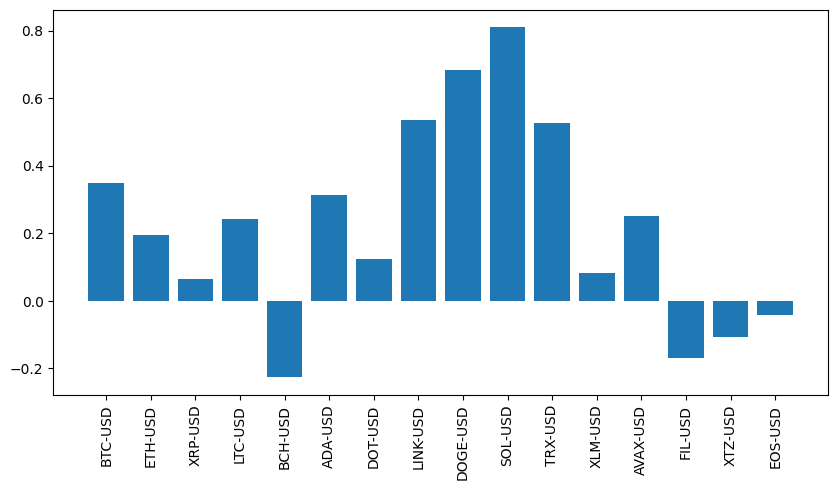

In [40]:
# Retorno medio anual percentual por criptomoeda
fig, ax = plt.subplots(figsize=(10, 5))
k = np.arange(len(mu))
ax.bar(k, mu)
ax.set_xticks(k, labels, rotation = 90)
plt.show()

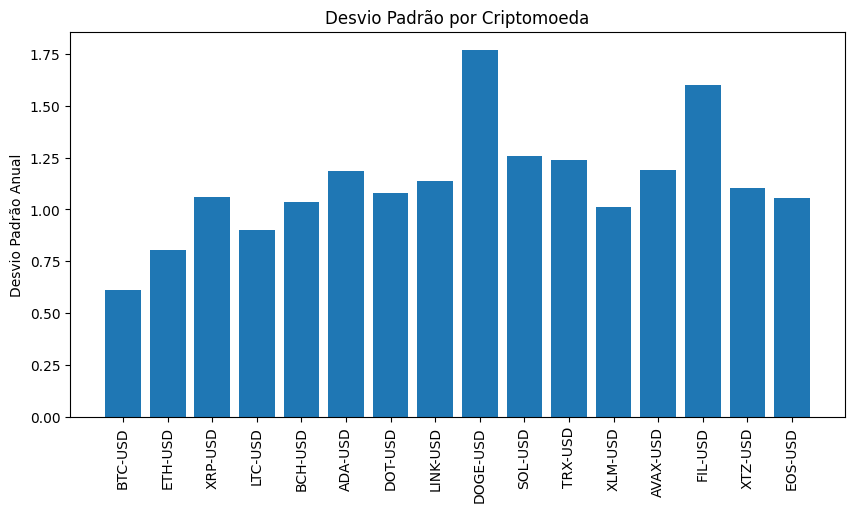

In [41]:
# Extraindo os desvios padrão da matriz de covariância
std_devs = np.sqrt(np.diag(cov))  # Extrai a diagonal e calcula a raiz quadrada

# Criando o gráfico
fig, ax = plt.subplots(figsize=(10, 5))
k = np.arange(len(std_devs))
ax.bar(k, std_devs)  # Multiplicando por 100 para converter em percentual
ax.set_xticks(k)
ax.set_xticklabels(labels, rotation=90)  # Ajusta os rótulos dos eixos x
ax.set_ylabel('Desvio Padrão Anual')
ax.set_title('Desvio Padrão por Criptomoeda')

plt.show()

DONE


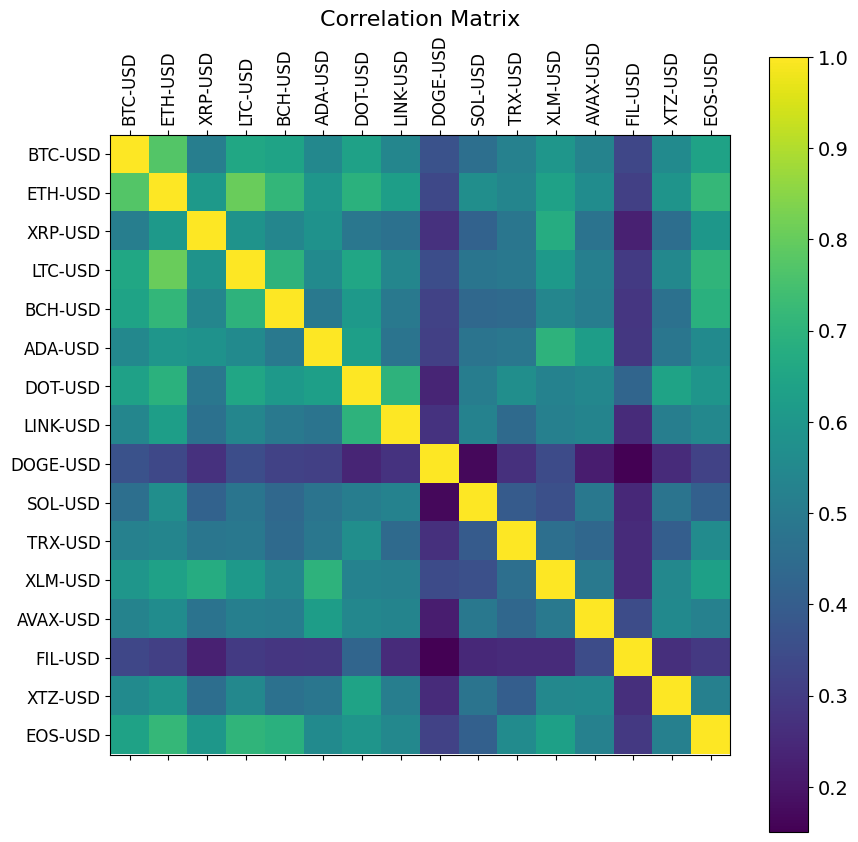

In [42]:
# Matriz de Correlação de Retornos
f = plt.figure(figsize=(10, 10))
plt.matshow(returns.corr(), fignum=f.number)
plt.xticks(k, labels, fontsize=12, rotation=90)
plt.yticks(k, labels, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
print("DONE")

In [43]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblemGA(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        # Problema com apenas 1 objetivo. Minimizar a função objetivo _evaluate que é sharpe * -1
        super().__init__(n_var=len(df.columns), n_obj=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu # @ é multiplicação de matriz 
        exp_risk = np.sqrt(x.T @ self.cov @ x) 
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = -sharpe #[exp_risk, -exp_return]
        # importante : Note o sinal negativo para Sharpe (queremos maximizar Sharpe), mas o pymoo esperar minimizar
        # 
        out["risk_return"] = [exp_risk, -exp_return]

In [44]:
from pymoo.core.repair import Repair

class PortfolioRepair(Repair): # Elimina pesos muito baixos (menores que 0.001)
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0 # Seta valores menores que 0.001 (1e-3) para zero
        X=X / X.sum(axis=1, keepdims=True) # normaliza o portfolio (somatorio dos pesos igual a 1) 
        return X

In [45]:
# Solução com GA
problem = PortfolioProblemGA(mu, cov)


algorithm = GA(
    pop_size=100,
    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()), # Simulated Binary Crossover, hyperparameters: prob of crossover, eta - parameter of crossover distribution
    mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()),  
    eliminate_duplicates=True)

res = minimize(problem, # observe que estamos minimizando
               algorithm,
               termination=('n_gen', 1000),# Criterio de termino: numero de geracoes!
               seed=1,
               verbose=False)

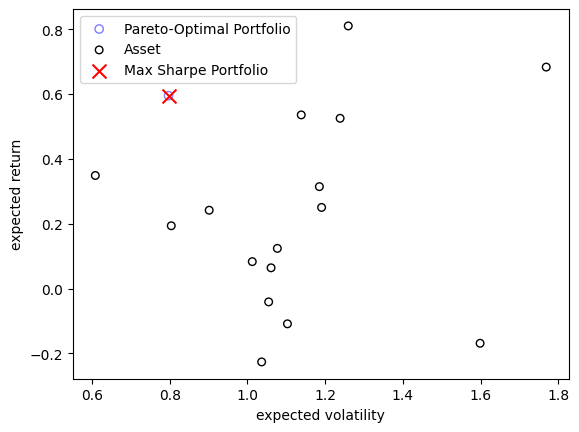

Allocation With Best Sharpe
SOL-USD = 0.40623
BTC-USD = 0.35191
TRX-USD = 0.11324
DOGE-USD = 0.10016
LINK-USD = 0.02846
ETH-USD = 0.00000
XRP-USD = 0.00000
LTC-USD = 0.00000
BCH-USD = 0.00000
ADA-USD = 0.00000
DOT-USD = 0.00000
XLM-USD = 0.00000
AVAX-USD = 0.00000
FIL-USD = 0.00000
XTZ-USD = 0.00000
EOS-USD = 0.00000


In [46]:
# Apresentação dos Resultados
#res.X: Design space values are
#res.F: Objective spaces values

X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
F = F * [1, -1]
max_sharpe = sharpe.argmax()

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
plt.legend()
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.show()

import operator

allocation = {name: w for name, w in zip(df.columns, X[max_sharpe])}
allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)

print("Allocation With Best Sharpe")
for name, w in allocation:
    print(f"{name:<5} = {w:.5f}")